In [1]:
pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 60.4 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import keras
from keras import layers
import tensorflow as tf
import jiwer
from jiwer import wer

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy()
else:
    strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")

# Dataset Setup

In [5]:
final_df = pd.read_parquet("/kaggle/input/svarah-indian-english-complete-dataset/combined.parquet")

In [6]:
final_df = final_df[["audio_filepath", "text"]]
final_df.dropna()
final_df.head(3)

,audio_filepath,text
0,{'bytes': b'RIFF|\x9e\x04\x00WAVEfmt \x10\x00\...,"some in the starting, then again I poured and ..."
1,{'bytes': b'RIFF\x02\xae\x02\x00WAVEfmt \x10\x...,"North 24 Parganas, South 24 Parganas, Murshida..."
2,{'bytes': b'RIFF\xd6\x96\x01\x00WAVEfmt \x10\x...,Breast cancers can be classified by different ...


In [7]:
#writing files
os.makedirs("/kaggle/working/sv_audio", exist_ok=True)
for index, row in final_df.iterrows():
    audio_data = row["audio_filepath"]
    
    audio_bytes = audio_data["bytes"]
    file_name = audio_data["path"]
    
    with open(f'sv_audio/{file_name}', "wb") as f:
        f.write(audio_bytes)

In [8]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz' "]
print(f"Number of characters: {len(characters)}")
print(f"Characters: {characters}")

Number of characters: 28
Characters: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", ' ']


In [9]:
char_to_num = keras.layers.StringLookup(
    vocabulary=characters, oov_token=""
)

num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

In [10]:
print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", ' '] (size =29)


# Preprocessing

In [11]:
import regex as re
from collections import Counter

In [12]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

# Use MFCC over STFT for better audio quality and feature extraction

In [13]:
def encode_single_sample(wav_file, label):
    ###########################################
    ##  Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file("/kaggle/working/sv_audio/" + wav_file)
    # 2. Decode the wav file
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    # 3. Change type to float
    audio = tf.cast(audio, tf.float32)

    # 4. Compute STFT
    stft = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(stft)

    # 5. Compute power spectrogram
    power_spectrogram = tf.square(spectrogram)

    sample_rate = 16000
    
    # 6. Compute mel filterbank
    num_mel_bins = 80
    lower_edge_hertz, upper_edge_hertz = 80.0, 7600.0
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, spectrogram.shape[-1], sample_rate,
        lower_edge_hertz, upper_edge_hertz
    )
    mel_spectrogram = tf.tensordot(power_spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrogram.set_shape(power_spectrogram.shape[:-1].concatenate([num_mel_bins]))

    # 7. Convert to log-mel spectrogram
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    # 8. Normalize
    means = tf.math.reduce_mean(log_mel_spectrogram, axis=0, keepdims=True)
    stddevs = tf.math.reduce_std(log_mel_spectrogram, axis=0, keepdims=True)
    log_mel_spectrogram = (log_mel_spectrogram - means) / (stddevs + 1e-10)

    ###########################################
    ##  Process the label
    ##########################################
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    label = char_to_num(label)

    return log_mel_spectrogram, label


In [14]:
batch_size = 32 * strategy.num_replicas_in_sync

from sklearn.model_selection import train_test_split

# Split dataset
svtrain_df, svval_df = train_test_split(final_df, test_size=0.2, random_state=42)

# Extract file paths properly
train_audio_paths = svtrain_df["audio_filepath"].apply(lambda x: x["path"]).tolist()
val_audio_paths = svval_df["audio_filepath"].apply(lambda x: x["path"]).tolist()

# Define the training dataset
svtrain_dataset = tf.data.Dataset.from_tensor_slices((train_audio_paths, svtrain_df["text"].tolist()))

svtrain_dataset = (
    svtrain_dataset
    .shuffle(buffer_size=len(svtrain_df))  # Shuffle dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()  # Cache for performance
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
svvalidation_dataset = tf.data.Dataset.from_tensor_slices((val_audio_paths, svval_df["text"].tolist()))

svvalidation_dataset = (
    svvalidation_dataset
    .map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [15]:
for sample, label in svtrain_dataset.take(1):
    print("Spectrogram Shape:", sample.shape)  # Expect (batch_size, time_steps, 193)
    print("Label Shape:", label.shape)


Spectrogram Shape: (32, 1968, 80)
Label Shape: (32, 251)


# Our Model is based off of the Deepseek2 voice model

- Why use CTCLoss Function ?
+  it is more dedicated to understand sentences (e.g. "Please close the door.") than word commands (e.g. "close") as it's efficient to learn the sentence's structure (spaces, end of sentence) and fitted to recognize unknown words from the training set.

In [16]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [17]:
with strategy.scope():
    def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
        """Model similar to DeepSpeech2."""
        # Model's input
        input_spectrogram = layers.Input((None, input_dim), name="input")
        # Expand the dimension to use 2D CNN.
        x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
        # Convolution layer 1
        x = layers.Conv2D(
            filters=32,
            kernel_size=[11, 41],
            strides=[2, 2],
            padding="same",
            use_bias=False,
            name="conv_1",
        )(x)
        x = layers.BatchNormalization(name="conv_1_bn")(x)
        x = layers.ReLU(name="conv_1_relu")(x)
        # Convolution layer 2
        x = layers.Conv2D(
            filters=32,
            kernel_size=[11, 21],
            strides=[1, 2],
            padding="same",
            use_bias=False,
            name="conv_2",
        )(x)
        x = layers.BatchNormalization(name="conv_2_bn")(x)
        x = layers.ReLU(name="conv_2_relu")(x)
        # Reshape the resulted volume to feed the RNNs layers
        x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
        # RNN layers
        for i in range(1, rnn_layers + 1):
            recurrent = layers.GRU(
                units=rnn_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                use_bias=True,
                return_sequences=True,
                reset_after=True,
                name=f"gru_{i}",
            )
            x = layers.Bidirectional(
                recurrent, name=f"bidirectional_{i}", merge_mode="concat"
            )(x)
            if i < rnn_layers:
                x = layers.Dropout(rate=0.5)(x)
        # Dense layer
        x = layers.Dense(units=rnn_units * 2, name="dense_1")(x)
        x = layers.ReLU(name="dense_1_relu")(x)
        x = layers.Dropout(rate=0.5)(x)
        # Classification layer
        output = layers.Dense(units=output_dim + 1, activation="softmax")(x)
        # Model
        model = keras.Model(input_spectrogram, output, name="Custom")
        # Optimizer
        opt = keras.optimizers.Adam(learning_rate=1e-4)
        # Compile the model and return
        model.compile(optimizer=opt, loss=CTCLoss)
        return model
    

In [18]:
with strategy.scope():
    model = build_model(
        input_dim=80,
        output_dim=char_to_num.vocabulary_size(),
        rnn_units=512,
    )
    
    model.summary()

Model: "Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, None, 80)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expand_dim (Reshape)                 │ (None, None, 80, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1 (Conv2D)                      │ (None, None, 40, 32)        │          14,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_bn (BatchNormalization)       │ (None, None, 40, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_relu (ReLU)                   │ (None, None, 40, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2 (Conv2D)                      │ (None, None, 20, 32)        │         236,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_bn (BatchNormalization)       │ (None, None, 20, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_relu (ReLU)                   │ (None, None, 20, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, None, 640)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 1024)          │       3,545,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, None, 1024)          │       4,724,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, None, 1024)          │       1,049,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1_relu (ReLU)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, None, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 23,775,614 (90.70 MB)

 Trainable params: 23,775,486 (90.70 MB)

 Non-trainable params: 128 (512.00 B)

In [19]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)


In [20]:
# Define the number of epochs.
epochs = 100
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(svvalidation_dataset)
# Train the model
history = model.fit(
    svtrain_dataset,
    validation_data=svvalidation_dataset,
    epochs=epochs,
    callbacks=[validation_callback],
)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 566ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 651ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 872ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 890ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 680ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━

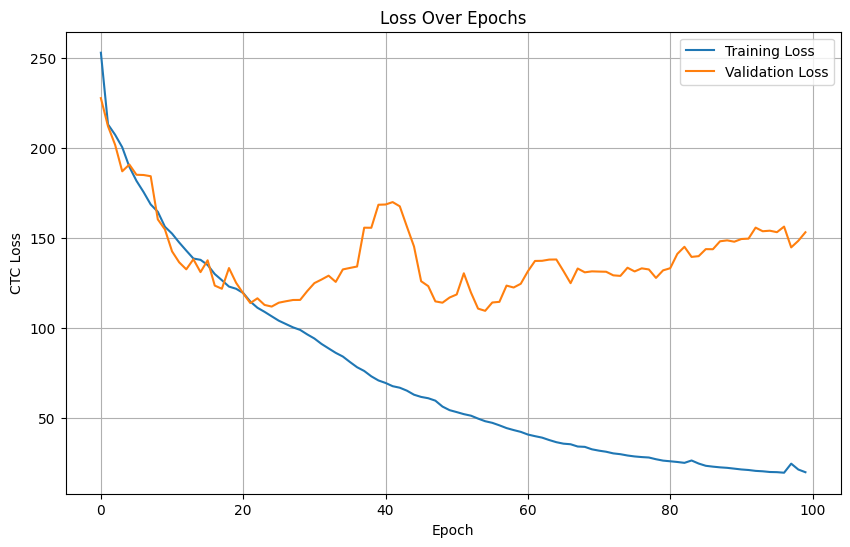

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('CTC Loss')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
from keras.models import save_model

In [23]:
model.save("/kaggle/working/deepspeechv2_custom.keras")